## Ex1

### Setting

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Lambda = [
[0, 2/5, 1/5, 0, 0],
[0, 0, 3/4, 1/4, 0],
[1/2, 0, 0, 1/3, 0],
[0, 0, 1/3, 0, 2/3],
[0, 1/3, 0, 1/3, 0]]

w = np.sum(Lambda, axis=1)
w_star = np.max(w)
# compute the off-diagonal part of Q
P_bar = Lambda/w_star 
# add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.2173913  0.14906832 0.26086957 0.1863354  0.1863354 ]


### 1ab

#### Simulation

In [23]:
# 1st approach: global clock with rate w_star and matrix P_bar
# set the number of steps in the simulation
n_steps = 1000000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 2
pos[0] = 2
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, as discussed in Remark 1
# NOTE: in the formula for t_next we use w_star, the rate of the "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of P_bar corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution P_bar[pos[i-1],:]
    pos[i] = np.random.choice(nstates, p=P_bar[pos[i-1],:])
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

# plot the trajectory for the first 20 jumps
#plt.plot(transition_times[0:20], pos[0:20], 'bo')
#plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(nstates)
# We have the time instants of all transitions, we now compute time intervals.
# np.diff computes the n-th discrete difference of a vector.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)

# for each state in the state space
for state in range(nstates):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
 
print("Estimate of pi_bar:", pi_estimate)


Estimate of pi_bar: [0.2181638  0.14905538 0.26132782 0.18558392 0.18586907]


#### Calculating average return time of node b

In [24]:
visits = np.argwhere(pos == 2).flatten()

sum = 0
count = 0
temp = 0
for i in range(len(visits) - 1):
    begin = visits[i]
    end = visits[i+1]

    if end >  begin + 1:
        for j in range(begin, end):
            sum = sum + intervals[j]
        sum = sum + temp
        count = count + 1

        temp = 0
    else:
        temp = temp + intervals[begin]

print(f'average return time: {sum/count}')
print(f'expected return time: {1 / (w[2] * pi_bar[2])}')

average return time: 4.601626824968556
expected return time: 4.6000000000000005


### 1cd

In [25]:
visits_o = np.argwhere(pos == 0).flatten()
visits_d = np.argwhere(pos == 4).flatten()

sum = 0
count = 0
index = 0

for i in range(len(visits_d)):
    if visits_d[i] < visits_o[index]:
        continue
    #else:
        #print(visits_d[i])

    for j in range(index, len(visits_o)-1):
        begin = visits_o[index]
        if visits_o[j+1] < visits_d[i]:
            pass
        else:
            
            for k in range(begin, visits_d[i]):
                sum += intervals[k]

            count += 1
            index = j + 1
            break


print(f'average hitting time o->d: {sum/count}')

linear_system_rhs = -np.diag(np.ones(5)) + np.diag(1/w).dot(Lambda)
linear_system_rhs[-1] = np.array([0,0,0,0,1])
linear_system_lhs = -1/w
linear_system_lhs[-1] = 0

solution = np.linalg.inv(linear_system_rhs).dot(linear_system_lhs)

print(f'expected hitting time o->d: {solution[0]}')

average hitting time o->d: 10.81876613644711
expected hitting time o->d: 10.76666666666667


### 1e

#### Setting

In [26]:
P = np.diag(1/w).dot(Lambda)
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
x_initial = np.random.random(size = 5)

#### Simulation

In [27]:
x = x_initial
P = np.diag(1/w).dot(Lambda)

for i in range(10000):
    x = P @ x

#### Result

In [28]:
print(f'equilibrium: {x}')
print(f'alpha: {pi.dot(x_initial)}')

equilibrium: [0.69592143 0.69592143 0.69592143 0.69592143 0.69592143]
alpha: 0.6959214305373127


#### Some explaination


C:\Users\Admin\AppData\Local\Temp\ipykernel_6340\3184319886.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G,pos=pos, edgelist = [('d','a')], connectionstyle="arc3,rad=0.3")


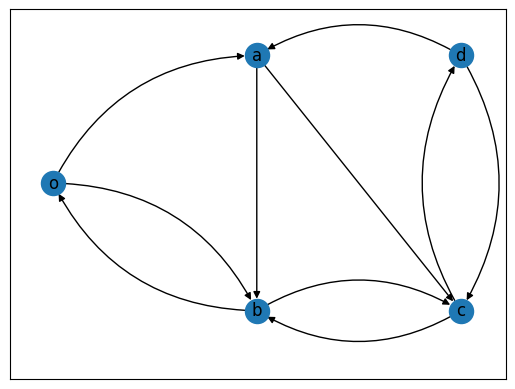

In [29]:
G = nx.DiGraph()
G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')

nodes = ['o','a','b','c','d']

for row_index, row in enumerate(Lambda):
    for column_index in range(len(row)):
        if Lambda[row_index][column_index] != 0:
            G.add_edge(nodes[row_index], nodes[column_index], weight = Lambda[row_index][column_index])

pos = {'o': [0,0], 'a': [2,1], 'd': [4,1], 'b': [2,-1], 'c': [4,-1]}

edge_list = [('o','a'), ('o','b'), ('b', 'o'), ('b','c'), ('c','b'), ('d','c'), ('c','d')]

nx.draw_networkx(G,pos = pos, connectionstyle="arc3,rad=-0.3", edgelist= edge_list)
nx.draw_networkx_edges(G,pos=pos, edgelist = [('a','b'),('a','c')])
nx.draw_networkx_edges(G,pos=pos, edgelist = [('d','a')], connectionstyle="arc3,rad=0.3")

In [30]:
print(f'G is strongly connected: {nx.is_strongly_connected(G)}')
print(f'G is aperiodic: {nx.is_aperiodic(G)}')


G is strongly connected: True
G is aperiodic: True


### 1f

In [31]:
def generate_x0():
    o = np.random.normal(0,np.sqrt(2), size=(1,))
    abc = np.random.normal(0,1, size= (3,))
    d = np.random.normal(0,np.sqrt(2), size=(1,))

    return np.concatenate((o, abc,d))

consensus_realizations = []

for i in range(10000):
    consensus_realizations.append(pi.dot(generate_x0()))


print(f'consensus variance: {np.square(pi).dot([2,1,1,1,2])}')
print(f'consensus variance estimation:{np.std(consensus_realizations) ** 2}')

consensus variance: 0.2593491124260355
consensus variance estimation:0.2575747765064897


#### 1g

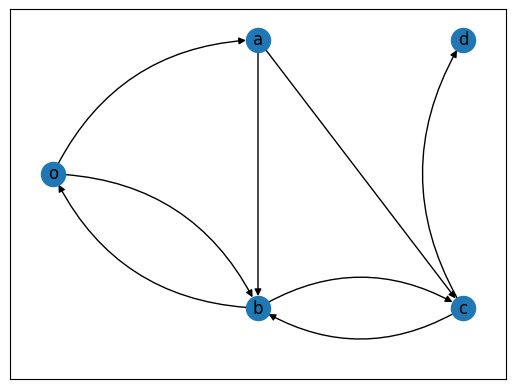

In [32]:
G_new = G.copy()
G_new.remove_edges_from([('d','a'), ('d', 'c')])

pos = {'o': [0,0], 'a': [2,1], 'd': [4,1], 'b': [2,-1], 'c': [4,-1]}

edge_list = [('o','a'), ('o','b'), ('b', 'o'), ('b','c'), ('c','b'), ('c','d')]

nx.draw_networkx(G,pos = pos, connectionstyle="arc3,rad=-0.3", edgelist= edge_list)
nx.draw_networkx_edges(G,pos=pos, edgelist = [('a','b'),('a','c')])

#### Setting

In [33]:
regular_id = [0,1,2,3]
stubborn_id = [4]

Q = P[:,regular_id][regular_id,:]
E = P[:,stubborn_id][regular_id,:]

n_nodes = 5
n_iter = 100

#### Simulation


Initial state: [ 0.76273632  0.24378333 -0.53791488 -0.3618103  -0.14264645] 

Final state: [-0.14264643 -0.14264643 -0.14264643 -0.14264645 -0.14264645] 



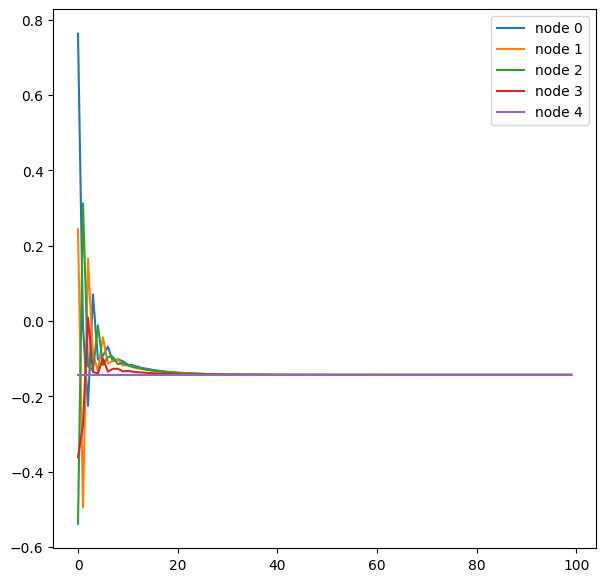

In [47]:
input = generate_x0()
x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = input[stubborn_id]
x[regular_id,0] = input[regular_id]
print("Initial state:", x[:,0], "\n")

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1]


print("Final state:", x[:,n_iter-1], "\n")

    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

In [35]:
np.linalg.inv(np.diag(np.ones(4)) - Q).dot(E)

array([[1.],
       [1.],
       [1.],
       [1.]])

### 1h

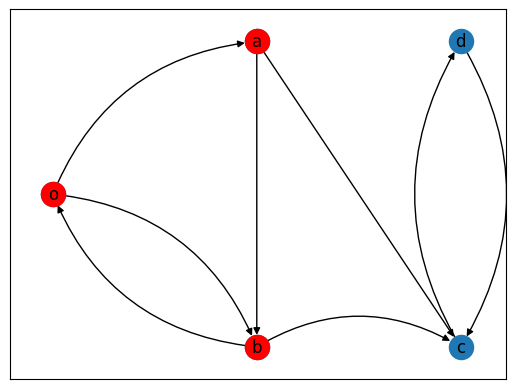

In [48]:
G_new = G.copy()
G_new.remove_edges_from([('d','a'), ('c', 'b')])

os = {'o': [0,0], 'a': [2,1], 'd': [4,1], 'b': [2,-1], 'c': [4,-1]}

edge_list = [('o','a'), ('o','b'), ('b', 'o'), ('b','c'), ('d','c'), ('c','d')]

nx.draw_networkx(G,pos = pos, connectionstyle="arc3,rad=-0.3", edgelist= edge_list)
nx.draw_networkx_edges(G,pos=pos, edgelist = [('a','b'),('a','c')])
nx.draw_networkx_nodes(G, pos = pos, nodelist=['o','a','b'], node_color='red')


In [49]:
print('strongly connected components:')

for s in nx.strongly_connected_components(G_new):
    print(s)

bool_var = nx.is_aperiodic(G_new.subgraph(nodes= ['d','c']))
print(f'is subgraph cd aperiodic?: {bool_var}')



strongly connected components:
{'d', 'c'}
{'b', 'o', 'a'}
is subgraph cd aperiodic?: False


In [56]:
Lambda_new = nx.adjacency_matrix(G_new).todense()
w_new = np.sum(Lambda_new, axis = 1)

In [57]:
P_new = np.diag(1/w_new).dot(Lambda_new)
values,vectors = np.linalg.eig(P_new.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)

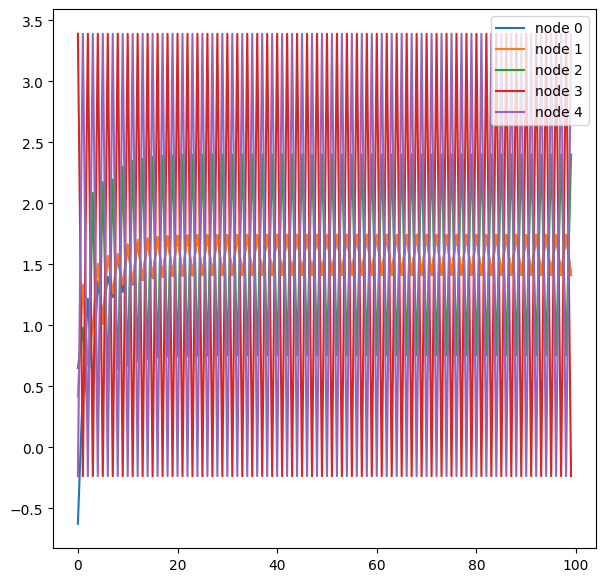

In [62]:
input = generate_x0()
x = np.zeros((n_nodes,n_iter))
x[:,0] = input

for t in range(1,n_iter):
    x[:,t] = P_new @ x[:,t-1]


fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()